# Diagnostic Explorations

This notebook provides hands-on examples of what can be learned from Gaussian process (GP) model-checking diagnostics.  The authoritative reference is Bastos and O'Hagan.

We cover the following questions:
   * How quickly do the empirical distributions of the Mahalanobis distance (MD) approach the theoretical distributions? We find that the GP case converges more quickly than the TP case.
   * How do particular misspecifications of the GP assumptions show up in the MD and pivoted Cholesky (PC) diagnostics? We find that
       * An overestimated length scale (with correctly identified marginal variance) leads to good PC at small index, and large PC at high index.
       * An underestimated length scale (with correctly identified marginal variance) leads to good PC at small index, and small PC at high index.
       * An overestimated marginal variance (with correctly identified length scale) leads to small PC at all indices.
       * An underestimated marginal variance (with correctly identified length scale) leads to large PC at all indices.
   * The credible interval diagnostic
       * Is robust against scaling factors
       * The empirical distribution can be approximated by a binomial distribution with an effective sample size.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ConstantKernel as C

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook

import gsum as gm

In [2]:
mpl.rcParams['figure.dpi'] = 120

## Mahalanobis Distance

Let's look at the reference distribution for the (squared) Mahalanobis distance $D_{MD}^2$.
Assume that we are computing $D_{MD}^2$ using $m$ validation points.
Bastos & O'Hagan state that for the Gaussian case, $D_{MD}^2$ is distributed as a standard chi-squared with $m$ degrees of freedom:
\begin{align}
    D_{MD}^2 \sim \chi^2_m
\end{align}
Note that this **does not** depend on the details of the mean or covariance matrix, only the number of datapoints $m$.

Similarly, for a Student-$t$ process with $\nu$ degrees of freedom, the $D_{MD}^2$ follows a (scaled) $F$-distribution $F(m,\nu)$ with a scale $\sigma = (\nu-2)m/\nu$.
By this I mean that $D_{MD}^2 / \sigma$ follows a standard $F(m,\nu)$ distribution.
Both the $\chi^2$ and the (scaled) $F$ distribution are available in Scipy and can be tested against distributions created from toy data.

In [3]:
n = 20
df = 4  # Must be greater than 2
n_samples = 10000
ls = 0.05
noise = 1e-6

X = np.linspace(0, 1, n)[:, None]
mean = np.zeros(n)
kernel = RBF(ls) + WhiteKernel(noise)
cov = kernel(X)
md_vals = np.linspace(0, 3*n, 100)

Using the above variables, test the GP case:

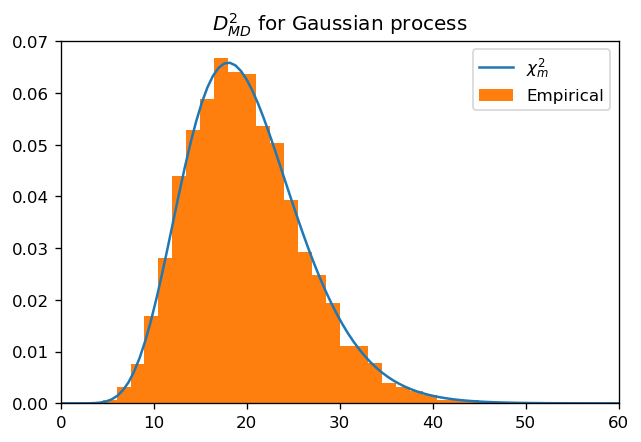

In [4]:
# With no df, diagnostics assumes GP
diagnostic_gp = gm.Diagnostic(mean, cov)
samples_gp = diagnostic_gp.samples(n_samples)
md_samples_gp = diagnostic_gp.md_squared(samples_gp)
chi2_dist = stats.chi2(df=n, scale=1)

plt.plot(md_vals, chi2_dist.pdf(md_vals), label=r'$\chi^2_m$')
plt.hist(md_samples_gp, density=True, bins=40, range=(md_vals.min(), md_vals.max()), label='Empirical')
plt.title(r'$D_{MD}^2$ for Gaussian process')
plt.legend()
plt.xlim(md_vals.min(), md_vals.max());

Now the TP case:

/Users/jordan.melendez/opt/miniconda3/envs/python-3.7/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1680: RuntimeWarning: divide by zero encountered in log
  lPx = m/2 * np.log(m) + n/2 * np.log(n) + (n/2 - 1) * np.log(x)


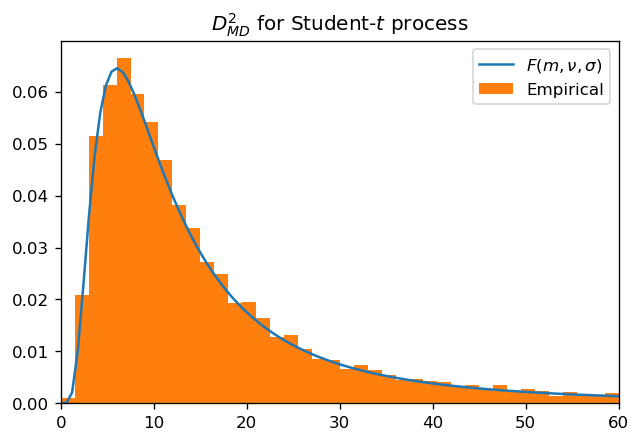

In [5]:
# With integer df, diagnostics assumes TP
diagnostic_tp = gm.Diagnostic(mean, cov, df=df)
samples_tp = diagnostic_tp.samples(n_samples)
np.random.seed(1)
md_samples_tp = diagnostic_tp.md_squared(samples_tp)
f_dist = stats.f(dfn=n, dfd=df, scale=(df-2)*n/df)

plt.plot(md_vals, f_dist.pdf(md_vals), label=r'$F(m,\nu,\sigma)$')
plt.hist(md_samples_tp, density=True, bins=40, range=(md_vals.min(), md_vals.max()), label='Empirical')
plt.title(r'$D_{MD}^2$ for Student-$t$ process')
plt.legend()
plt.xlim(md_vals.min(), md_vals.max());

In [6]:
def dist_boxplot(dist, q1=0.25, q3=0.75, whislo=0.025, whishi=0.975, label=None, ax=None, other_stats=None, **kwargs):
    """Creates a boxplot computed from a Scipy.stats-like distribution."""
    if ax is None:
        ax = plt.gca()
    stat_dict = [{'med': dist.median(), 'q1': dist.ppf(q1), 'q3': dist.ppf(q3),
                  'whislo': dist.ppf(whislo), 'whishi': dist.ppf(whishi)}]
    if label is not None:
        stat_dict[0]['label'] = label
    if other_stats is not None:
        stat_dict = [*stat_dict, *other_stats]
    ax.bxp(stat_dict, showfliers=False, **kwargs)
    return ax

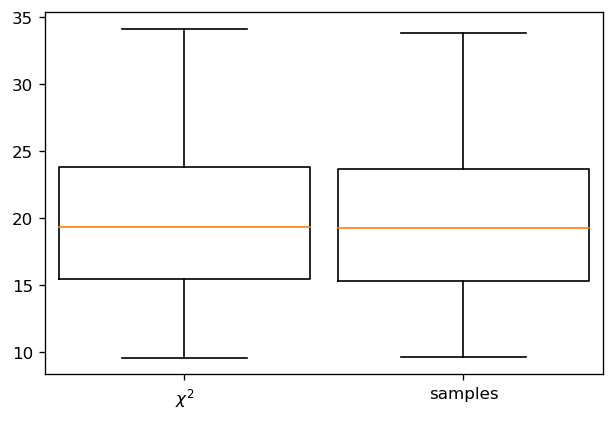

In [7]:
fig, ax = plt.subplots()
stat_dict_gp = cbook.boxplot_stats(md_samples_gp, whis=[2.5, 97.5], labels=['samples'], bootstrap=None)
ax = dist_boxplot(chi2_dist, label=r'$\chi^2$', other_stats=stat_dict_gp, widths=0.9)

Not bad. Now look at the Student $t$ version.

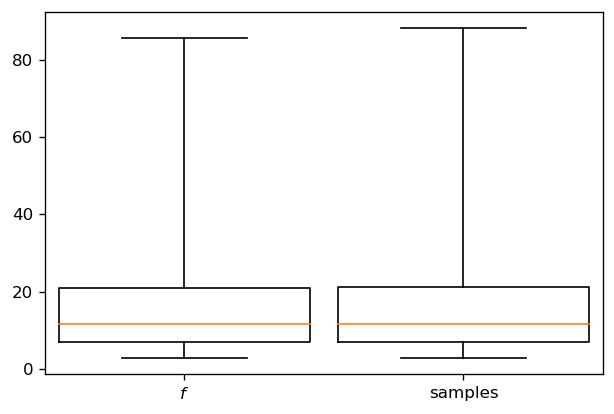

In [8]:
fig, ax = plt.subplots()
stat_dict_tp = cbook.boxplot_stats(md_samples_tp, whis=[2.5, 97.5], labels=['samples'], bootstrap=None)
ax = dist_boxplot(f_dist, label=r'$f$', other_stats=stat_dict_tp, widths=0.9)

As we see above, even with 10000 samples (!), the $2\sigma$ bands computed for the TP reference distribution by sampling are not terribly accurate compared to the true reference distribution. This is because the tails are quite long, so achieving this accuracy can take a lot of data.

## Variance Decompositions

Here we demonstrate how to interpret Pivoted Cholesky plots.


In [174]:
def plot_decomposition_old(data_cov, est_mean, est_cov, X, n=20, seed=1, **kwargs):
    rng = np.random.RandomState(seed=seed)
    # samples = stats.multivariate_normal(true_mean, cov).rvs(n)
    samples = rng.multivariate_normal(est_mean, data_cov, size=n).T
    dgn = gm.Diagnostic(est_mean, est_cov, random_state=seed)
    eigen_samples = dgn.eigen_errors(samples)
    pc_samples = dgn.pivoted_cholesky_errors(samples)

    fig, axes = plt.subplots(1, 2, constrained_layout=True, **kwargs)
    axes[0].plot(X.ravel(), samples)
    axes[0].set_title('Curves')
#     axes[1].plot(np.arange(1, len(true_mean)+1), eigen_samples, ls='', marker='o')
#     axes[1].axhline(2, 0, 1, ls='--', color='grey')
#     axes[1].axhline(-2, 0, 1, ls='--', color='grey')
#     axes[1].set_title('Eigen')
    
    axes[1].plot(np.arange(1, len(true_mean)+1), pc_samples, ls='', marker='o')
    axes[1].axhline(2, 0, 1, ls='--', color='grey')
    axes[1].axhline(-2, 0, 1, ls='--', color='grey')
    axes[1].set_title('Pivoted Cholesky')
    return fig, axes


def plot_decomposition(data, kernel, X, mask=None, random_state=1, test_mask=None, interp=False, **kwargs):
    gp = gm.ConjugateGaussianProcess(kernel=kernel, random_state=random_state, **kwargs)
    if interp:
        gp.fit(X[mask], data[mask])
        means, cov = gp.predict(X, return_cov=True)
        data = data - means
        if test_mask is None:
            test_mask = ~mask
        data_pred = data[test_mask]
        X_pred = X[test_mask]
        cov_pred = cov[test_mask][:, test_mask]
    else:
        if test_mask is None:
            test_mask = slice(None)
        X_pred = X[test_mask]
        cov_pred = gp.cov(X_pred)
        data_pred = data[test_mask]
    dgn = gm.Diagnostic(np.zeros(len(X_pred)), cov_pred, random_state=random_state)
    eigen_samples = dgn.eigen_errors(data_pred)
    pc_samples = dgn.pivoted_cholesky_errors(data_pred)

    fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
    
    if mask is not None:
        axes[0].set_xticks(X[mask].ravel())
    axes[0].plot(X.ravel(), data)
    axes[0].set_xticks(X_pred.ravel(), minor=True)
    axes[0].set_title('Curves')
    axes[0].axhline(0, 0, 1, c='lightgrey', zorder=0)
    if interp:
        axes[0].plot(X[mask].ravel(), np.zeros(sum(mask)), c='k', ls='', marker='o', fillstyle='none')
    
    axes[1].plot(np.arange(1, len(X_pred)+1), pc_samples, ls='', marker='o')
#     axes[1].plot(np.arange(1, len(X_pred)+1), eigen_samples, ls='', marker='o')
    axes[1].axhline(2, 0, 1, ls='--', color='grey')
    axes[1].axhline(-2, 0, 1, ls='--', color='grey')
    axes[1].set_title('Pivoted Cholesky')
    return fig, axes

In [188]:
n_decomp = 301
n_simulated_curves = 6
X_decomp = np.linspace(0, 3, n_decomp)[:, None]
mask_train = np.array([i % 100 == 0 for i in range(n_decomp)])
mask_valid = np.array([i % 25 == 0 for i in range(n_decomp)]) & ~mask_train

# n_decomp = 101
# n_simulated_curves = 6
# X_decomp = np.linspace(0, 1, n_decomp)[:, None]
# mask_train = np.array([i % 20 == 0 for i in range(n_decomp)])
# mask_valid = np.array([i % 5 == 0 for i in range(n_decomp)]) & ~mask_train

true_mean = np.zeros(n_decomp)
true_cov = kernel(X_decomp)

ls = 0.8
noise = 1e-5
kernel = RBF(ls, length_scale_bounds='fixed') + WhiteKernel(noise, noise_level_bounds='fixed')


gp_kwargs = dict(center=0, disp=0, df=np.inf, scale=1, optimizer=None, nugget=0)

In [265]:
def draw_lengthscales(ls_true, ls_est=None, std=1, ax=None):
    if ax is None:
        ax = plt.gca()
    # Draw length scale
    ax.annotate("", xy=(0.2, 1.5*std), xytext=(0.2+ls_true, 1.5*std),
                arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1,
                                color='k'), annotation_clip=False)
    ax.text(0.2 + ls_true/2, 1.5*std, r'$\ell_{true}$', horizontalalignment='center',
                verticalalignment='bottom')
    
    if ls_est is not None:
        ax.annotate("", xy=(0.2, 1.4*std), xytext=(0.2+ls_est, 1.4*std),
                    arrowprops=dict(arrowstyle="<->", capstyle='projecting', lw=1,
                                    color='k'), annotation_clip=False)
        ax.text(0.2 + ls_est/2, 1.4*std, r'$\ell_{est}$', horizontalalignment='center',
                    verticalalignment='top')

def draw_std(std_true, std_est=None, ax=None):
    if ax is None:
        ax = plt.gca()

    ax.set_yticks([-std_true, std_true])
    ax.set_yticklabels([r'$-\sigma_{true}$', r'$\sigma_{true}$'])
        
    if std_est is not None:
        if std_est < std_true:
            yticks = [-std_true, -std_est, std_est, std_true]
            yticklabels = [r'$-\sigma_{true}$', r'$-\sigma_{est}$', r'$\sigma_{est}$', r'$\sigma_{true}$']
        else:
            yticks = [-std_est, -std_true, std_true, std_est]
            yticklabels = [r'$-\sigma_{est}$', r'$-\sigma_{true}$', r'$\sigma_{true}$', r'$\sigma_{est}$']
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticklabels)

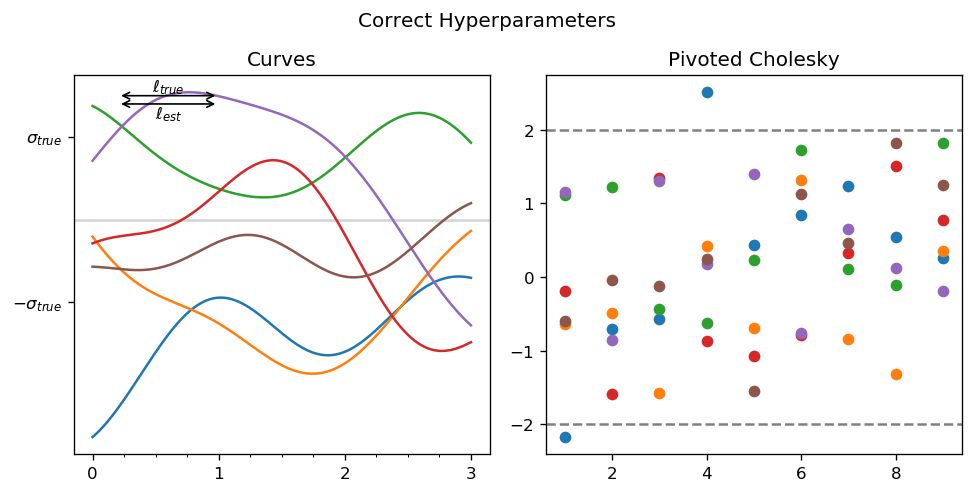

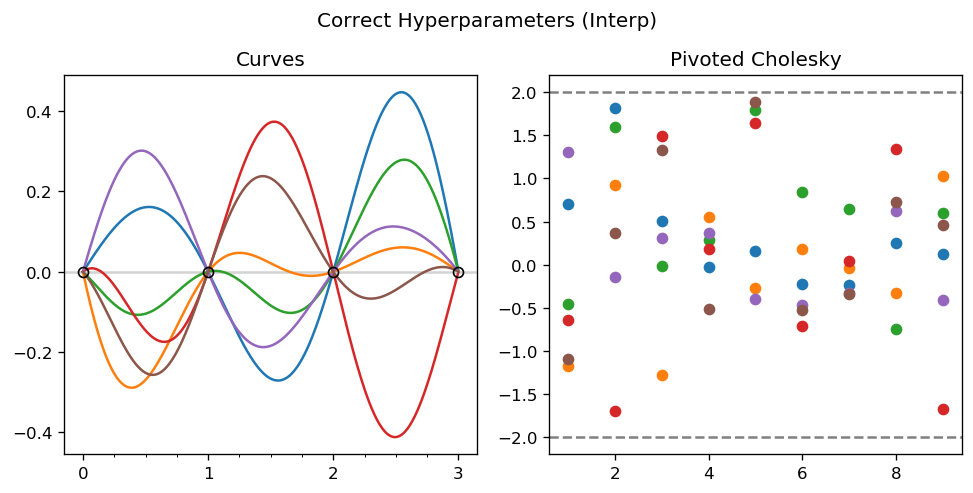

In [266]:
kernel_correct = RBF(length_scale=ls, length_scale_bounds='fixed') + \
    WhiteKernel(noise, noise_level_bounds='fixed')
gp = gm.ConjugateGaussianProcess(kernel_correct, **gp_kwargs)
data = gp.sample_y(X_decomp, n_simulated_curves)

fig, axes = plot_decomposition(
    data, kernel=kernel, X=X_decomp, mask=mask_train, test_mask=mask_valid, interp=False, **gp_kwargs
)
fig.suptitle('Correct Hyperparameters')
draw_std(1, ax=axes[0])
draw_lengthscales(ls, ls, ax=axes[0], std=1)
# plt.annotate()
fig, axes = plot_decomposition(
    data, kernel=kernel, X=X_decomp, mask=mask_train, test_mask=mask_valid, interp=True, **gp_kwargs
)

fig.suptitle('Correct Hyperparameters (Interp)');

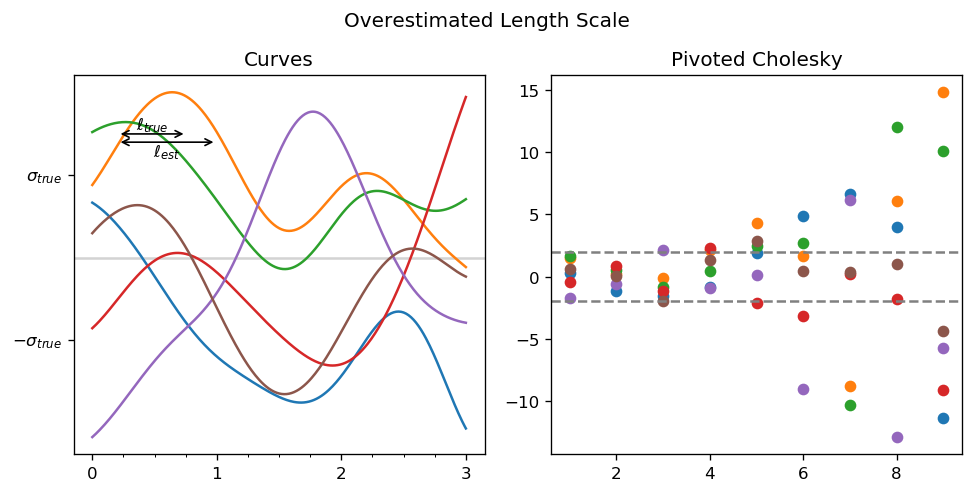

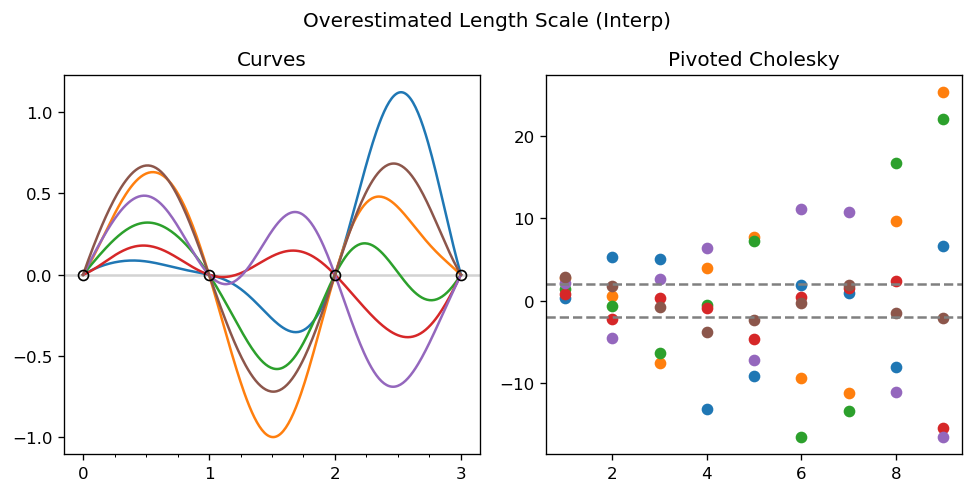

In [267]:
ls_small = 0.7*ls
kernel_small_ls = RBF(length_scale=ls_small, length_scale_bounds='fixed') + \
    WhiteKernel(noise, noise_level_bounds='fixed')
gp = gm.ConjugateGaussianProcess(kernel_small_ls, **gp_kwargs)
data = gp.sample_y(X_decomp, n_simulated_curves, random_state=1)

# fig, axes = plot_decomposition(
#     kernel_small_ls(X_decomp), true_mean=true_mean, true_cov=true_cov,
#     X=X_decomp, n=20)
fig, axes = plot_decomposition(
    data, kernel=kernel, X=X_decomp, mask=mask_train, test_mask=mask_valid, interp=False, **gp_kwargs
)
fig.suptitle('Overestimated Length Scale')
draw_std(1, ax=axes[0])
draw_lengthscales(ls_small, ls, ax=axes[0], std=1)

fig, axes = plot_decomposition(
    data, kernel=kernel, X=X_decomp, mask=mask_train, test_mask=mask_valid, interp=True, **gp_kwargs
)
fig.suptitle('Overestimated Length Scale (Interp)');

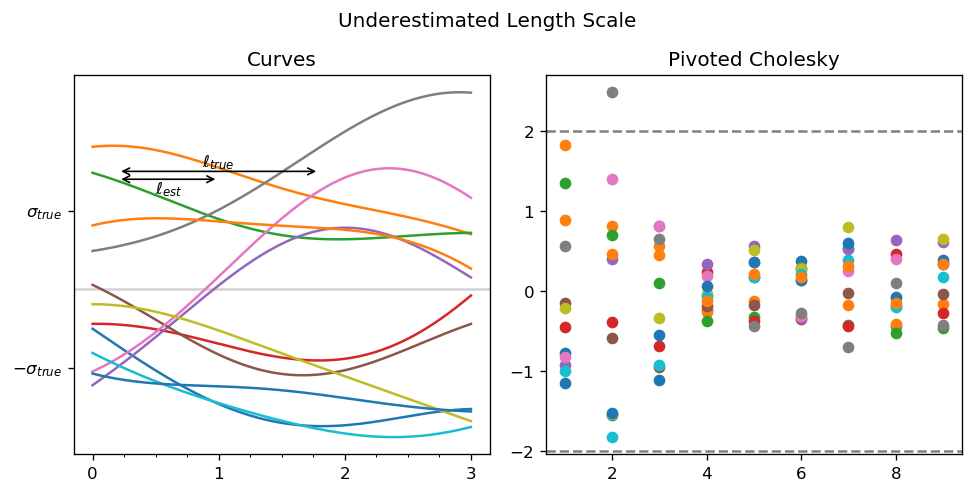

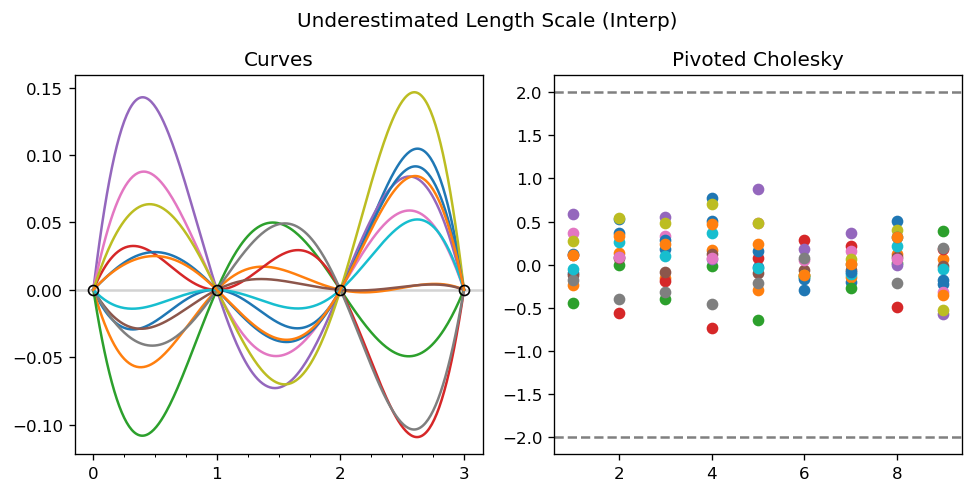

In [274]:
ls_large = ls*2
kernel_large_ls = RBF(length_scale=ls_large, length_scale_bounds='fixed') + \
    WhiteKernel(noise, noise_level_bounds='fixed')
gp = gm.ConjugateGaussianProcess(kernel_large_ls, **gp_kwargs)
data = gp.sample_y(X_decomp, 2*n_simulated_curves, random_state=1)

# fig, axes = plot_decomposition_old(
#     kernel_large_ls(X_decomp), est_mean=true_mean, est_cov=true_cov,
#     X=X_decomp, n=10)
fig, axes = plot_decomposition(
    data, kernel=kernel, X=X_decomp, mask=mask_train, test_mask=mask_valid, interp=False, **gp_kwargs
)
fig.suptitle('Underestimated Length Scale')
draw_std(1, ax=axes[0])
draw_lengthscales(ls_large, ls, ax=axes[0], std=1)

fig, axes = plot_decomposition(
    data, kernel=kernel, X=X_decomp, mask=mask_train, test_mask=mask_valid, interp=True, **gp_kwargs
)
fig.suptitle('Underestimated Length Scale (Interp)');

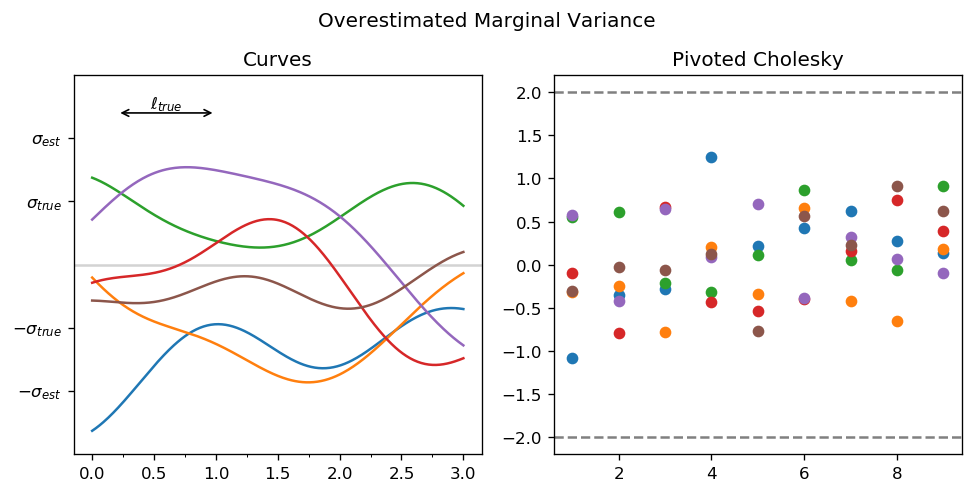

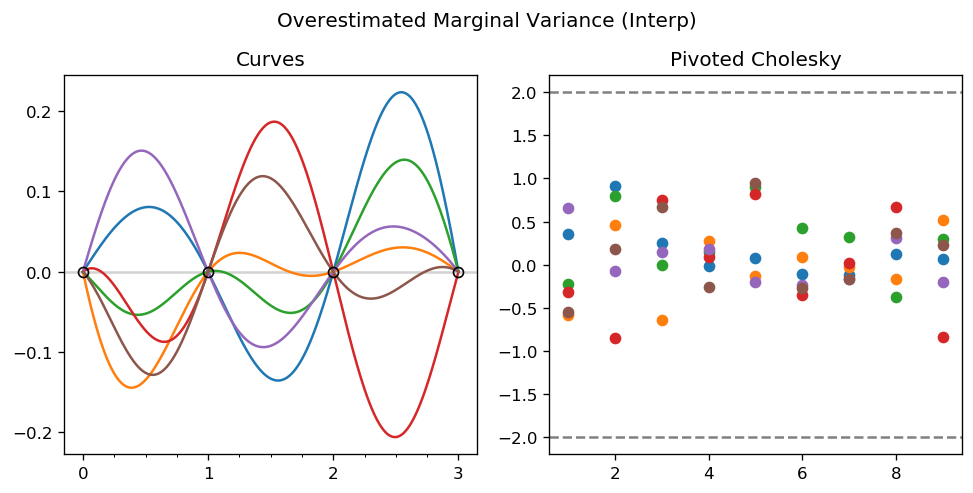

In [277]:
std_small = 0.5
kernel_small_sd = C(constant_value=std_small**2) * RBF(length_scale=ls) + WhiteKernel(noise)
gp = gm.ConjugateGaussianProcess(kernel_small_sd, **gp_kwargs)
data = gp.sample_y(X_decomp, n_simulated_curves)

# fig, axes = plot_decomposition_old(
#     kernel_small_sd(X_decomp), est_mean=true_mean, est_cov=true_cov,
#     X=X_decomp, n=20)
fig, axes = plot_decomposition(data, kernel=kernel, X=X_decomp, test_mask=mask_valid, interp=False, **gp_kwargs)
fig.suptitle('Overestimated Marginal Variance')
draw_std(std_small, 1, ax=axes[0])
draw_lengthscales(ls, ax=axes[0], std=0.8)
axes[0].set_ylim(-1.5, 1.5)


fig, axes = plot_decomposition(data, kernel=kernel, X=X_decomp, mask=mask_train, test_mask=mask_valid, interp=True,**gp_kwargs)
fig.suptitle('Overestimated Marginal Variance (Interp)');

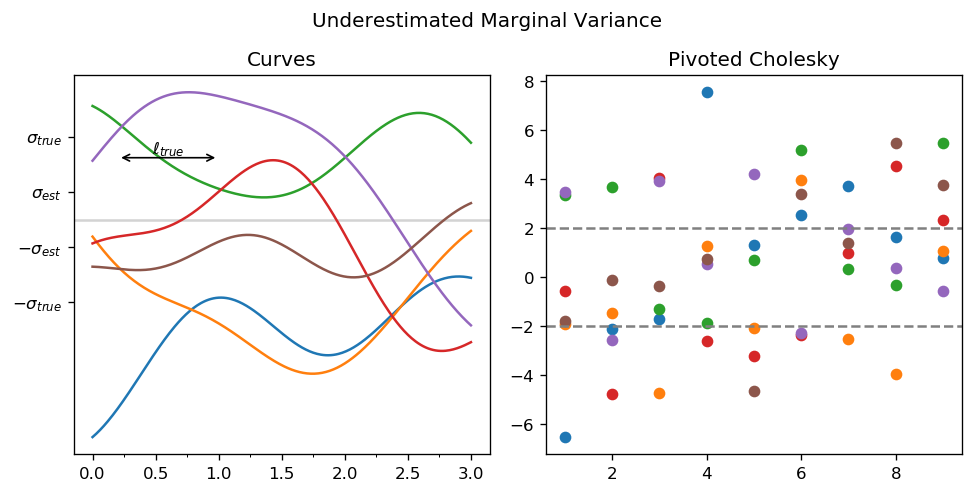

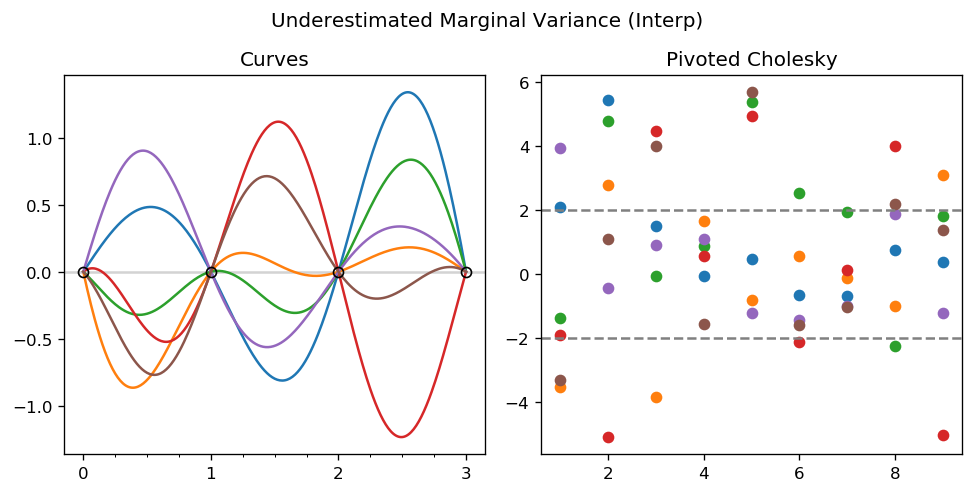

In [278]:
std_large = 3
kernel_large_sd = C(constant_value=std_large**2) * RBF(length_scale=ls) + WhiteKernel(noise)
gp = gm.ConjugateGaussianProcess(kernel_large_sd, **gp_kwargs)
data = gp.sample_y(X_decomp, n_simulated_curves)

# fig, axes = plot_decomposition_old(
#     kernel_large_sd(X_decomp), est_mean=true_mean, est_cov=true_cov,
#     X=X_decomp, n=20)
fig, axes = plot_decomposition(data, kernel=kernel, X=X_decomp, test_mask=mask_valid, interp=False, **gp_kwargs)
fig.suptitle('Underestimated Marginal Variance')
draw_std(std_large, 1, ax=axes[0])
draw_lengthscales(ls, ax=axes[0], std=1.5)
# axes[0].set_ylim(-1.5, 1.5)

fig, axes = plot_decomposition(data, kernel=kernel, X=X_decomp, mask=mask_train, test_mask=mask_valid, interp=True, **gp_kwargs)
fig.suptitle('Underestimated Marginal Variance (Interp)');

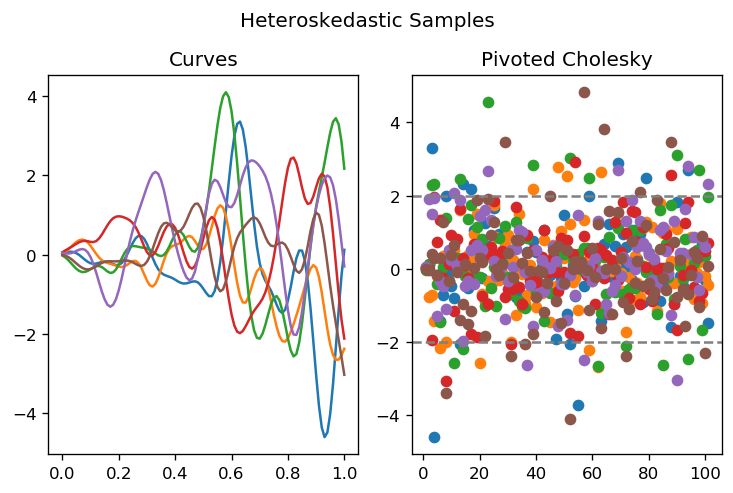

In [20]:
hetero_cov = (np.linspace(0.1, 2, n_decomp) * np.linspace(0.1, 2, n_decomp)[:, None]) * kernel(X_decomp)

fig, axes = plot_decomposition_old(
    hetero_cov, est_mean=true_mean, est_cov=true_cov,
    X=X_decomp, n=n_simulated_curves)
# fig, axes = plot_decomposition(
#     hetero_cov, est_mean=true_mean, est_cov=true_cov,
#     X=X_decomp)

fig.suptitle('Heteroskedastic Samples');

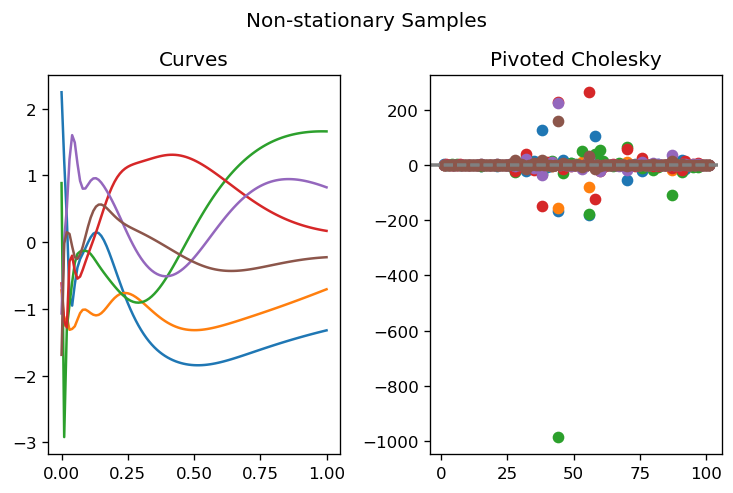

In [21]:
def rbf_var_ls(X, Xp=None, ls_func=None, **ls_kwargs):
    """An rbf kernel with a length scale function to introduce non-stationarity
    
    See MacKay's Intoduction to Gaussian Processes, Eq. (49).
    """
    if Xp is None:
        Xp = X
    diff = X[:, None, ...] - Xp[None, ...]
    dist = np.linalg.norm(diff, axis=-1)

    L = ls_func(X, **ls_kwargs)
    Lp = ls_func(Xp, **ls_kwargs)[:, None]
    ls_prefactor = np.sqrt(2 * L * Lp / (L**2 + Lp**2))
    return ls_prefactor * np.exp(- dist**2 / (L**2 + Lp**2))

# nonstationary_cov = rbf_var_ls(X_decomp, ls_func=lambda X: (X.ravel()+1e-5)**2)
nonstationary_cov = rbf_var_ls(X_decomp, ls_func=lambda X: np.abs(X.ravel()+1e-5))

fig, axes = plot_decomposition_old(
    nonstationary_cov, est_mean=true_mean, est_cov=true_cov,
    X=X_decomp, n=n_simulated_curves)

fig.suptitle('Non-stationary Samples');

It looks like length scale problems appear at large index, while marginal variance problems affect all indices equally. Non-stationarity appears at large index as well.

## Credible Interval Diagnostic

The credible interval diagnostic reference distribution must be generated by sampling. We've seen above that for the Mahalanobis distance, the reference is actually independent of the exact form of the covariance function. We know that's not true for the CI, since the length scale affects how wide the bands are.
But how robust is the distribution against scaling factors?
We would expect that a scalar wouldn't change the reference at all, but what about something like $Q(x)$, which shows up in the truncation distribution?

In [ ]:
scales = [1, 200, np.logspace(1, 3, n), np.linspace(0.1, 0.9, n)**2/(1 - np.linspace(0.1, 0.9, n)),
          ]
intervals = np.linspace(0, 1, 100)
band_perc = [0.68, 0.95]

fig, ax = plt.subplots()
for s, scale in enumerate(scales):
    scale = np.atleast_1d(scale)
    cov_n = scale * scale[:, None] * cov
    dgn_n = gm.Diagnostic(mean, cov_n)
    samps_n = dgn_n.samples(n_samples)
    dci_ref = dgn_n.credible_interval(samps_n, intervals)
    bands = np.array([np.percentile(dci_ref, [100*(1.-bi)/2, 100*(1.+bi)/2], axis=0)
                          for bi in band_perc])

    greys = mpl.cm.get_cmap('Greys')
    for i, perc in enumerate(band_perc):
        ax.plot(intervals, bands[i, 0], c=f'C{s+1}', ls=['-', '--', '-.', ':'][s], zorder=s)
        ax.plot(intervals, bands[i, 1], c=f'C{s+1}', ls=['-', '--', '-.', ':'][s], zorder=s)

That's good news that even rather dramatic logarithmicly changing scale dependence doesn't change the reference by much at all (at least for the Gaussian RBF kernel).

One thing that has always bothered me a bit is the fact that the reference is jagged due to the finite number of points along a curve used to compute the reference distribution. What if we used a more finely sampled GP from the same process to generate the reference distribution?

In [ ]:
nn = 10*n
Xnew = np.linspace(0, 1, nn)[:, None]
# scales = [1, 200, np.logspace(1, 3, nn), #np.linspace(0.1, 0.9, n)**2/(1 - np.linspace(0.1, 0.9, n)),
#           np.exp(np.linspace(0, 5, n))]
intervals = np.linspace(0, 1, 100)
band_perc = [0.68, 0.95]

mean_new = np.zeros(Xnew.shape[0])
cov_new = kernel(Xnew)
print(nn)
fig, ax = plt.subplots()
length_prev = 0
for i, n_i in enumerate(range(1, nn, 10)):
    mean_n = mean_new[::n_i]
    
    length = len(mean_n)
    if length == length_prev:
        continue
    
    dgn_n = gm.Diagnostic(mean_n, cov_new[::n_i, ::n_i])
    samps_n = dgn_n.samples(n_samples)
    dci_ref = dgn_n.credible_interval(samps_n, intervals)
    bands = np.array([np.percentile(dci_ref, [100*(1.-bi)/2, 100*(1.+bi)/2], axis=0)
                          for bi in band_perc])

    greys = mpl.cm.get_cmap('Greys')
#     for i, perc in enumerate([band_perc[1]]):
#         ax.plot(intervals, bands[i, 0], c=f'C{n_i//10 % 10}', zorder=-n_i)
#         ax.plot(intervals, bands[i, 1], c=f'C{n_i//10 % 10}', zorder=-n_i)
    ax.plot(intervals, bands[0, 0], c=f'C{i % 10}', zorder=-i, label=fr'$n={{{length}}}$')
    ax.plot(intervals, bands[1, 1], c=f'C{i % 10}', zorder=-i)
    length_prev = length
ax.plot([0, 1], [0,1], c='k')
ax.legend();

The top bands are the $2\sigma$ CI, whereas the lower bands are the $1\sigma$ CI.

It looks like the reference distribution from the finely sampled GP is more-or-less a lower bound to the credible intervals computed from the lower resolution GPs. So that means if we use the finely sampled GP (for prettiness sake) when the true GP is more sparse, then we might end up concluding failure when there actually is no failure to be found.


How about the CI diagnostic for different kernels? The easiest comparison would be the Matern for different values of $\nu$, with $\nu=\infty$ equivalent to the Gaussian kernel.

In [ ]:
nus = [0.5, 1.5, 2.5, 10]
covs = [*[(Matern(ls, nu=nu) + WhiteKernel(1e-5))(X) for nu in nus],
        cov
       ]
names = [*nus, r'\infty']
intervals = np.linspace(0, 1, 100)
band_perc = [0.68, 0.95]

fig, ax = plt.subplots()
for s, cov_i in enumerate(covs):
    cov_n = cov_i
    dgn_n = gm.Diagnostic(mean, cov_n)
    samps_n = dgn_n.samples(n_samples)
    dci_ref = dgn_n.credible_interval(samps_n, intervals)
    bands = np.array([np.percentile(dci_ref, [100*(1.-bi)/2, 100*(1.+bi)/2], axis=0)
                          for bi in band_perc])

    greys = mpl.cm.get_cmap('Greys')
    for i, perc in enumerate(band_perc):
        if i == 0:
            label = fr'$\nu = {names[s]}$'
        else:
            label = None
        ax.plot(intervals, bands[i, 0], c=f'C{s}', zorder=s, label=label)
        ax.plot(intervals, bands[i, 1], c=f'C{s}', zorder=s)
ax.legend();

Now back to the question from many months ago: do GP credible interval diagnostic bands correspond to a binomial distribution with an effective sample size?
And can that $N_{eff}$ be derived for each kernel?
In the notes, I proposed
\begin{align}
    N_{eff} = \frac{\Delta x}{\ell}
\end{align}
where $\Delta x$ is the difference between the minimum and maximum $x$ used in the GP regression.
As we can see below, this approximately holds so long as there are a sufficient number of points.

In [ ]:
ax = plt.gca()

binom_68_u = []
binom_68_l = []
binom_95_u = []
binom_95_l = []


N = 101
Xvals = np.linspace(1, N, N)[:,None]
# diffX = Xvals[1,0] - Xvals[0,0]
diffX = np.max(Xvals) - np.min(Xvals)
ls_val = 10


binom_CI_domain = np.linspace(1e-5, 1, 100)
# Neff_vals = min(diffX / ls_val, N)
Neff_vals = diffX / ls_val * np.ones_like(binom_CI_domain)
# Neff_vals = N + (diffX / ls_val - N) * binom_CI_domain
print('my Neff:', diffX / ls_val)
# Neff_vals = diffX / ls_val / np.log(binom_CI_domain+1)

for i, p_decimal in enumerate(binom_CI_domain):
    Neff = Neff_vals[i]
    nn = p_decimal*Neff
    beta_args = {"a": nn+1, "b": Neff-nn+1, "loc": 0, "scale": 1}

    interval_68_perc = gm.hpd(stats.beta(**beta_args), alpha=0.68)

    binom_68_u.append(interval_68_perc[0])
    binom_68_l.append(interval_68_perc[1])
    
    interval_95_perc = gm.hpd(stats.beta(**beta_args), alpha=0.95)

    binom_95_u.append(interval_95_perc[0])
    binom_95_l.append(interval_95_perc[1])


ax.fill_betweenx(
        binom_CI_domain, binom_95_u, binom_95_l,
        facecolor=greys(0.2),
        color=greys(0.2),
        zorder=0)

ax.fill_betweenx(
        binom_CI_domain, binom_68_u, binom_68_l,
        facecolor=greys(0.4),
        color=greys(0.4),
        zorder=1)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

binom_68_u2 = []
binom_68_l2 = []
binom_95_u2 = []
binom_95_l2 = []

# binom_CI_domain = np.linspace(1e-5, 1, 100)
# # Neff = min(diffX / ls_val, N)
# Neff_vals = diffX / ls_val / binom_CI_domain
# # print("Neff", Neff)
# for i, p_decimal in enumerate(binom_CI_domain):
#     Neff = Neff_vals[i]
#     norm = Neff
#     binom = stats.binom(n=Neff, p=p_decimal)
#     binom_68_l2.append(binom.ppf((1-0.68)/2) / norm)
#     binom_68_u2.append(binom.ppf((1+0.68)/2) / norm)
    
#     binom_95_l2.append(binom.ppf((1-0.95)/2) / norm)
#     binom_95_u2.append(binom.ppf((1+0.95)/2) / norm)


# ax.fill_between(
#         binom_CI_domain, binom_95_u2, binom_95_l2,
#         facecolor=greys(0.2),
#         color=greys(0.2),
#         zorder=0)

# ax.fill_between(
#         binom_CI_domain, binom_68_u2, binom_68_l2,
#         facecolor=greys(0.4),
#         color=greys(0.4),
#         zorder=1)


np.random.seed(1)
intervals = np.linspace(0, 1, 100)
band_perc = [0.68, 0.95]
mean_new = np.zeros(N)
ones_new = np.ones(N)
cov_new = (RBF(ls_val) + WhiteKernel(1e-7))(Xvals)
# cov_new = (Matern(ls_val) + WhiteKernel(1e-7))(Xvals)
# cov_new = (Matern(ls_val, nu=0.5) + WhiteKernel(1e-7))(Xvals)
dgn_n = gm.Diagnostic(mean_new, cov_new)
samps_n = dgn_n.samples(n_samples)
dci_ref = dgn_n.credible_interval(samps_n, intervals)
bands = np.array([np.percentile(dci_ref, [100*(1.-bi)/2, 100*(1.+bi)/2], axis=0)
                      for bi in band_perc])

print('Vallejos et al. Neff:', ones_new @ np.linalg.solve(cov_new, ones_new))

greys = mpl.cm.get_cmap('Greys')
for i, perc in enumerate(band_perc):
    if i == 0:
        label = fr'$\nu = {names[s]}$'
    else:
        label = None
    ax.plot(intervals, bands[i, 0], c=f'C{0}', zorder=s, label=label)
    ax.plot(intervals, bands[i, 1], c=f'C{0}', zorder=s)
# ax.axvline(0.5, 0, 1, c='grey')
ax.plot([0, 1], [0,1], c='k');